In [1]:
%matplotlib inline

import os
import sys
import emcee
import scipy
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact
from functools import partial

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from tutorial_utils import *

sns.set_style('darkgrid')

%load_ext line_profiler

In [40]:
import timeit

def generate_timings(f):
    cov_func = example_squared_exponential
    for n in np.linspace(1000, 7000, 15):
        n = round(n)
        X, y = generate_training_data(n)
        start_time = timeit.default_timer()
        count = 0
        while (timeit.default_timer() - start_time < 1. or
               count < 3):
            count = count + 1
            f(cov_func, X, y, np.array([4]), meas_noise=0.1)
        timing = (timeit.default_timer() - start_time) / count
        print(f"Timing with {n} measurements: {timing}")
        yield n, timing

In [41]:
def build_cov(cov_func, X, y, x_test, meas_noise):
    return cov_func(X, X)

sizes, cov_times = zip(*generate_timings(build_cov))

Timing with 1000 measurements: 0.010966444260860875
Timing with 1429 measurements: 0.029567415264489895
Timing with 1857 measurements: 0.04599362995676612
Timing with 2286 measurements: 0.07288611414177078
Timing with 2714 measurements: 0.10996038090088404
Timing with 3143 measurements: 0.14824125528269047
Timing with 3571 measurements: 0.1923397748323623
Timing with 4000 measurements: 0.24471876380266622
Timing with 4429 measurements: 0.2895515627460554
Timing with 4857 measurements: 0.3467779040026168
Timing with 5286 measurements: 0.41685885600357625
Timing with 5714 measurements: 0.4757849909947254
Timing with 6143 measurements: 0.5608832183255194
Timing with 6571 measurements: 0.679194415997093
Timing with 7000 measurements: 0.7235571520092586


In [42]:
def do_fit(cov_func, X, y, x_test, meas_noise):
    return example_fit(cov_func, X, y, meas_noise=meas_noise)

sizes, fit_times = zip(*generate_timings(do_fit))

Timing with 1000 measurements: 0.02210946413106285
Timing with 1429 measurements: 0.058885927767465436
Timing with 1857 measurements: 0.11529694611413611
Timing with 2286 measurements: 0.21725487059447915
Timing with 2714 measurements: 0.2985302717424929
Timing with 3143 measurements: 0.426867347327061
Timing with 3571 measurements: 0.5650588963374806
Timing with 4000 measurements: 0.7753618666708159
Timing with 4429 measurements: 0.8701273786718957
Timing with 4857 measurements: 1.0803146850084886
Timing with 5286 measurements: 1.3163710226654075
Timing with 5714 measurements: 1.5871828566693391
Timing with 6143 measurements: 1.9681410416766691
Timing with 6571 measurements: 2.282145808004619
Timing with 7000 measurements: 2.637045596668031


In [43]:

dummy_L = np.tril(np.random.normal(size=(10000, 10000)))

def do_predict(cov_func, X, y, x_test, meas_noise):
    dummy_fit = {
        "train_locations": X,
        "information": y,
        "cholesky": dummy_L[:y.size,:y.size],
        "cov_func": cov_func
    }

    return example_predict(dummy_fit, x_test)

sizes, predict_times = zip(*generate_timings(do_predict))

Timing with 1000 measurements: 0.0014721378881778731
Timing with 1429 measurements: 0.00414396594624874
Timing with 1857 measurements: 0.006555671215489556
Timing with 2286 measurements: 0.013066399168954896
Timing with 2714 measurements: 0.017379782603178493
Timing with 3143 measurements: 0.023161047250720334
Timing with 3571 measurements: 0.02988518403007594
Timing with 4000 measurements: 0.036652413462953906
Timing with 4429 measurements: 0.04546626750115221
Timing with 4857 measurements: 0.0542954765781025
Timing with 5286 measurements: 0.06450207274974673
Timing with 5714 measurements: 0.0783370606144532
Timing with 6143 measurements: 0.08930013899710805
Timing with 6571 measurements: 0.1003897029964719
Timing with 7000 measurements: 0.11401577388945346


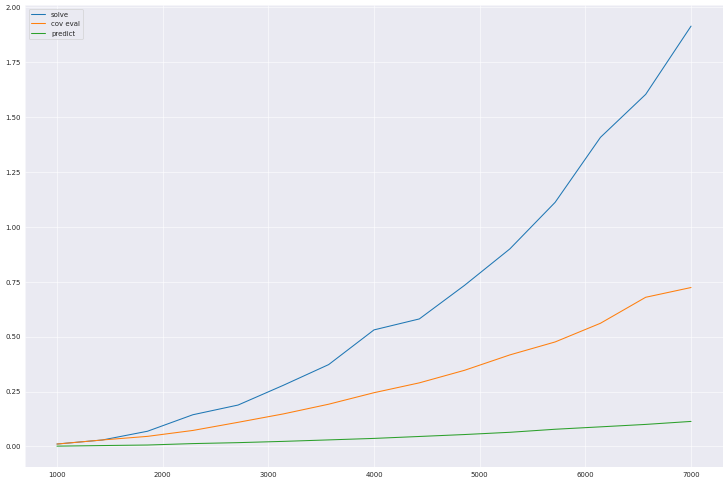

In [50]:
solve_times = np.array(fit_times) - cov_times

plt.plot(sizes, solve_times, label="solve")
plt.plot(sizes, cov_times, label="cov eval")
plt.plot(sizes, predict_times, label="predict")
plt.legend()

As you can see, the time required for the solve quickly exceeds the covariance matrix construction and the prediction times. This bottleneck is what prevents dense Gaussian processes from being a viable model for moderate sized datasets, let alone large ones. Thankfully there are a number of options for acclerating these steps, though each comes with some tradeoffs. Here we're going to focus on sparse Gaussian processes, which use a set of "inducing points" to capture the information in the data. If the number of required inducing points is much smaller than the number of measurements the computation savings are significant.